In [12]:
!pip install pandera
import pandas as pd
import seaborn as sns
import pandera as pa
from pandera.pandas import Column, Check, DataFrameSchema

In [13]:
df = sns.load_dataset("iris")
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [14]:
schema = DataFrameSchema({
    "sepal_length": Column(float, Check(lambda s: s.between(0, 10)), nullable=False),
    "sepal_width":  Column(float, Check(lambda s: s.between(0, 10)), nullable=False),
    "petal_length": Column(float, Check(lambda s: s.between(0, 10)), nullable=False),
    "petal_width":  Column(float, Check(lambda s: s.between(0, 10)), nullable=False),
    "species":      Column(str, Check.isin(["setosa","versicolor","virginica"]), nullable=False)
}, coerce=True, strict=True)


In [15]:
validated_df = schema.validate(df)
print("✅ Data hợp lệ theo schema:")
display(validated_df)
validated_df = schema.validate(df, head=None, tail=None, sample=None)
print("✅ Toàn bộ dữ liệu ({} dòng) đã được kiểm tra & hợp lệ".format(validated_df.shape[0]))

✅ Data hợp lệ theo schema:


,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


✅ Toàn bộ dữ liệu (150 dòng) đã được kiểm tra & hợp lệ


In [16]:
# Cell: Tính min/max thực tế của từng feature
numeric_cols = ["sepal_length", "sepal_width", "petal_length", "petal_width"]
min_max = {col: (df[col].min(), df[col].max()) for col in numeric_cols}

# Cell: Định nghĩa schema dựa trên min_max
schema = pa.DataFrameSchema({
    "sepal_length": Column(float,
        Check(lambda s: s.between(min_max["sepal_length"][0], min_max["sepal_length"][1])),
        nullable=False
                           ),
    "sepal_width": Column(float,
        Check(lambda s: s.between(min_max["sepal_width"][0], min_max["sepal_width"][1])),
        nullable=False
                          ),
    "petal_length": Column(float,
        Check(lambda s: s.between(min_max["petal_length"][0], min_max["petal_length"][1])),
        nullable=False
                           ),
    "petal_width": Column(float,
        Check(lambda s: s.between(min_max["petal_width"][0], min_max["petal_width"][1])),
        nullable=False
                          ),
    "species": Column(str,
        Check.isin(["setosa", "versicolor", "virginica"]),
        nullable=False
                      )
}, coerce=True, strict=True)

validated_df = schema.validate(df)
print("✅ Data hợp lệ theo schema:")
display(validated_df)
validated_df = schema.validate(df, head=None, tail=None, sample=None)
print("✅ Toàn bộ dữ liệu ({} dòng) đã được kiểm tra & hợp lệ".format(validated_df.shape[0]))

✅ Data hợp lệ theo schema:


,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


✅ Toàn bộ dữ liệu (150 dòng) đã được kiểm tra & hợp lệ


In [17]:
# 1. Kiểm tra missing
print("Missing values:")
print(df.isnull().sum())

# 2A. Imputation nhanh với pandas (Mean cho numeric, Mode cho categorical)
numeric_cols = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
cat_cols     = ['species']

# Điền giá trị thiếu numeric bằng mean
for col in numeric_cols:
    df[col] = df[col].fillna(df[col].mean())

# Điền giá trị thiếu categorical bằng mode
mode_values = df[cat_cols].mode().iloc[0].to_dict()
df.fillna(mode_values, inplace=True)

print("\nMissing values sau khi điền giá trị:")
print(df.isnull().sum())

# Lưu lại kết quả
validated_df_imputed = df.copy()
print(f"\n✅ Imputation hoàn thành. Không còn giá trị thiếu.")

Missing values:
sepal_length    0
sepal_width     0
petal_length    0
petal_width     0
species         0
dtype: int64

Missing values sau khi điền giá trị:
sepal_length    0
sepal_width     0
petal_length    0
petal_width     0
species         0
dtype: int64

✅ Imputation hoàn thành. Không còn giá trị thiếu.


In [18]:
from sklearn.preprocessing import LabelEncoder

# LabelEncoder cho biến target
le = LabelEncoder()
validated_df['species_encoded'] = le.fit_transform(validated_df['species'])

# Tách X (features) và y (target)
X = validated_df.drop(['species'], axis=1)
y = validated_df['species_encoded']

print("Classes:", list(le.classes_))
display(X)

Classes: ['setosa', 'versicolor', 'virginica']


,sepal_length,sepal_width,petal_length,petal_width,species_encoded
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
numeric_cols = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

# Fit & transform
X_scaled = scaler.fit_transform(X[numeric_cols])
X_scaled = pd.DataFrame(X_scaled, columns=[f"{c}_scaled" for c in numeric_cols])

# Kết hợp với các cột khác (nếu có)
X_prepared = pd.concat([X_scaled], axis=1)
display(X_prepared)

,sepal_length_scaled,sepal_width_scaled,petal_length_scaled,petal_width_scaled
0,-0.900681,1.019004,-1.340227,-1.315444
1,-1.143017,-0.131979,-1.340227,-1.315444
2,-1.385353,0.328414,-1.397064,-1.315444
3,-1.506521,0.098217,-1.283389,-1.315444
4,-1.021849,1.249201,-1.340227,-1.315444
...,...,...,...,...
145,1.038005,-0.131979,0.819596,1.448832
146,0.553333,-1.282963,0.705921,0.922303
147,0.795669,-0.131979,0.819596,1.053935
148,0.432165,0.788808,0.933271,1.448832


In [20]:
from sklearn.preprocessing import StandardScaler
import joblib

scaler = StandardScaler()
numeric_cols = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

scaler.fit(X[numeric_cols])


# Fit scaler trên X và transform
X_scaled = scaler.fit_transform(X[numeric_cols])
# Đưa kết quả về DataFrame để dễ thao tác
X_scaled = pd.DataFrame(
    X_scaled,
    columns=[f"{c}_scaled" for c in numeric_cols],
    index=X.index
)

# Nếu muốn, bạn có thể kiểm tra mean và std:
print("Mean sau scaling:", X_scaled.mean().round(2).tolist())
print("Std sau scaling:", X_scaled.std().round(2).tolist())

X_scaled


Mean sau scaling: [-0.0, -0.0, -0.0, -0.0]
Std sau scaling: [1.0, 1.0, 1.0, 1.0]


,sepal_length_scaled,sepal_width_scaled,petal_length_scaled,petal_width_scaled
0,-0.900681,1.019004,-1.340227,-1.315444
1,-1.143017,-0.131979,-1.340227,-1.315444
2,-1.385353,0.328414,-1.397064,-1.315444
3,-1.506521,0.098217,-1.283389,-1.315444
4,-1.021849,1.249201,-1.340227,-1.315444
...,...,...,...,...
145,1.038005,-0.131979,0.819596,1.448832
146,0.553333,-1.282963,0.705921,0.922303
147,0.795669,-0.131979,0.819596,1.053935
148,0.432165,0.788808,0.933271,1.448832


In [21]:
# Tạo diện tích Sepal & Petal
X_prepared['sepal_area'] = validated_df['sepal_length'] * validated_df['sepal_width']
X_prepared['petal_area'] = validated_df['petal_length'] * validated_df['petal_width']

# Scale diện tích Sepal & Petal:
X_prepared[['sepal_area_scaled', 'petal_area_scaled']] = scaler.fit_transform(
    X_prepared[['sepal_area', 'petal_area']]
)

# Chọn các cột để huấn luyện
features_final = [
    'sepal_length_scaled', 'sepal_width_scaled',
    'petal_length_scaled', 'petal_width_scaled',
    'sepal_area_scaled', 'petal_area_scaled'
]
X_final = X_prepared[features_final]

print("✅ X_final:", X_final.shape)
display(X_final)


✅ X_final: (150, 6)


,sepal_length_scaled,sepal_width_scaled,petal_length_scaled,petal_width_scaled,sepal_area_scaled,petal_area_scaled
0,-0.900681,1.019004,-1.340227,-1.315444,0.008098,-1.174041
1,-1.143017,-0.131979,-1.340227,-1.315444,-0.932024,-1.174041
2,-1.385353,0.328414,-1.397064,-1.315444,-0.830551,-1.178299
3,-1.506521,0.098217,-1.283389,-1.315444,-1.063343,-1.169783
4,-1.021849,1.249201,-1.340227,-1.315444,0.052866,-1.174041
...,...,...,...,...,...,...
145,1.038005,-0.131979,0.819596,1.448832,0.679614,1.312835
146,0.553333,-1.282963,0.705921,0.922303,-0.618650,0.789058
147,0.795669,-0.131979,0.819596,1.053935,0.500543,0.980684
148,0.432165,0.788808,0.933271,1.448832,0.972096,1.410777


In [22]:
from sklearn.preprocessing import StandardScaler
import joblib

# Tính x_area trước khi scale
area_cols = ['sepal_area', 'petal_area']
area_data = validated_df[['sepal_length', 'sepal_width']].prod(axis=1).to_frame('sepal_area')
area_data['petal_area'] = validated_df['petal_length'] * validated_df['petal_width']

# Fit scaler cho area
scaler_area = StandardScaler().fit(area_data)

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Đã có X_final (6 feature) và y (species_encoded)
# Chia 80% train / 20% test, random_state để tái lập
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, test_size=0.2, random_state=42, stratify=y
)

print("Kích thước:")
print(f"  X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"  X_test : {X_test.shape}, y_test : {y_test.shape}")


Kích thước:
  X_train: (120, 6), y_train: (120,)
  X_test : (30, 6), y_test : (30,)


In [24]:
# Logistic Regression
lr = LogisticRegression(max_iter=200)
lr.fit(X_train, y_train)

# Dự đoán trên tập test
y_pred_lr = lr.predict(X_test)

print("✅ Logistic Regression đã train xong.")


✅ Logistic Regression đã train xong.


In [25]:
# Random Forest với 100 cây
rf = RandomForestClassifier(n_estimators=100, random_state=42)

rf.fit(X_train, y_train)

# Dự đoán
y_pred_rf = rf.predict(X_test)

print("✅ Random Forest đã train xong.")


✅ Random Forest đã train xong.


--- Logistic Regression ---
Accuracy : 0.933
Precision: 0.933
Recall   : 0.933
F1-score : 0.933

Classification Report:
               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.90      0.90      0.90        10
   virginica       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30



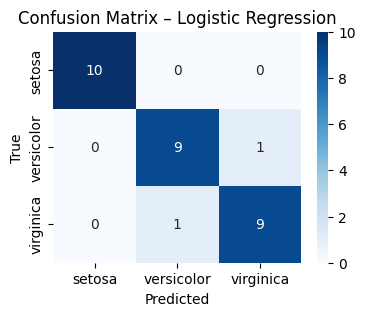

--- Random Forest ---
Accuracy : 0.933
Precision: 0.933
Recall   : 0.933
F1-score : 0.933

Classification Report:
               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.90      0.90      0.90        10
   virginica       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30



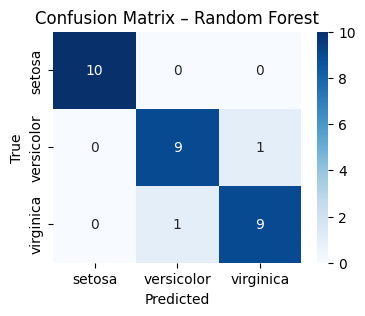

In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate(y_true, y_pred, title=""):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted')
    rec = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    print(f"--- {title} ---")
    print(f"Accuracy : {acc:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall   : {rec:.3f}")
    print(f"F1-score : {f1:.3f}")
    print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=le.classes_))
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.title(f"Confusion Matrix – {title}")
    plt.show()

# Đánh giá LR
evaluate(y_test, y_pred_lr, title="Logistic Regression")

# Đánh giá RF
evaluate(y_test, y_pred_rf, title="Random Forest")


In [27]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import pandas as pd

results = {
    'Model': [
        'Logistic Regression',
        'Random Forest'
    ],
    'Accuracy': [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_rf)
    ],
    'Precision': [
        precision_score(y_test, y_pred_lr, average='weighted'),
        precision_score(y_test, y_pred_rf, average='weighted'),
    ],
    'Recall': [
        recall_score(y_test, y_pred_lr, average='weighted'),
        recall_score(y_test, y_pred_rf, average='weighted')
    ],
    'F1-score': [
        f1_score(y_test, y_pred_lr, average='weighted'),
        f1_score(y_test, y_pred_rf, average='weighted')
    ]
}

df_results = pd.DataFrame(results)
display(df_results.sort_values(by='F1-score'))

,Model,Accuracy,Precision,Recall,F1-score
0,Logistic Regression,0.933333,0.933333,0.933333,0.933333
1,Random Forest,0.933333,0.933333,0.933333,0.933333


In [28]:
import joblib
import os

os.makedirs("models", exist_ok=True)

# Lưu mô hình
joblib.dump(rf, "models/best_model.pkl")

# Lưu scaler
joblib.dump(scaler, "models/scaler.pkl")

# Lưu LabelEncoder
joblib.dump(le, "models/label_encoder.pkl")

# Lưu scaler_area
joblib.dump(scaler_area, "models/scaler_area.pkl")

print("✅ Đã lưu xong các mô hình")


✅ Đã lưu xong các mô hình


In [29]:
from google.colab import files

# Tải từng file
files.download("models/best_model.pkl")
files.download("models/scaler.pkl")
files.download("models/label_encoder.pkl")
files.download("models/scaler_area.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>